In [1]:
!pip install -q transformers accelerate scipy safetensors segments-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 4.6 MB/s eta 0:00:00


In [2]:
import random
import requests

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy import ndimage
from PIL import Image
from huggingface_hub import hf_hub_download
from segments import SegmentsClient
from segments.export import colorize
from segments.utils import bitmap2file
from getpass import getpass

In [3]:
api_key = getpass("Enter your API key: ")
segments_client = SegmentsClient(api_key)

In [122]:
dataset_identifier = "youssefelhami/crab-cakes-101"

samples = segments_client.get_samples(dataset_identifier)
dataset = segments_client.get_dataset(dataset_identifier)

In [123]:
print(type(dataset))

<class 'segments.typing.Dataset'>


In [124]:
from segments.utils import get_semantic_bitmap, load_label_bitmap_from_url

In [125]:
sample = samples[1]

In [126]:
from segments import SegmentsDataset

In [127]:
dataset_name = dataset_identifier

In [128]:
release = segments_client.get_release(dataset_name, 'v0.1')
# dataset = SegmentsDataset(release, task='segmentation', filter_by='labeled')

In [129]:
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled'])

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 954/954 [00:34<00:00, 28.04it/s]

Initialized dataset with 954 images.


In [130]:
from segments.utils import export_dataset

In [131]:
export_dataset(dataset, export_format='coco-panoptic')

Exporting dataset. This may take a while...


100%|██████████| 954/954 [00:24<00:00, 38.63it/s]

Exported to ./export_coco-panoptic_youssefelhami_crab-cakes-101_v0.1.json. Images and labels in segments/youssefelhami_crab-cakes-101/v0.1


('./export_coco-panoptic_youssefelhami_crab-cakes-101_v0.1.json',
 'segments/youssefelhami_crab-cakes-101/v0.1')

In [132]:
img_names = []
for sample in samples:
  img_names.append(sample.name)


In [133]:
# image_path = "/content/segments/youssefelhami_apple-pie-101/v0.1/1005649.jpg"
# image_ground_truth = '/content/segments/youssefelhami_apple-pie-101/v0.1/1005649_label_ground-truth.png'
# image_label_coco = "/content/segments/youssefelhami_apple-pie-101/v0.1/1005649_label_ground-truth_coco-panoptic.png"

In [134]:
dataset_name = dataset_identifier.replace("/", "_")

dataset_name

'youssefelhami_crab-cakes-101'

In [135]:
def get_link(name):
  image_path = "/content/segments/"+ dataset_name+"/v0.1/" + name
  image_ground_truth = '/content/segments/'+ dataset_name+'/v0.1/' + name.split('.')[0] + '_label_ground-truth.png'
  image_label_coco = "/content/segments/"+ dataset_name+"/v0.1/"+ name.split('.')[0] +"_label_ground-truth_coco-panoptic.png"
  return image_path, image_ground_truth, image_label_coco

In [136]:
image_path, image_ground_truth, image_label_coco = get_link(img_names[0])

print(image_path)
print(image_ground_truth)
print(image_label_coco)

/content/segments/youssefelhami_crab-cakes-101/v0.1/100038.jpg
/content/segments/youssefelhami_crab-cakes-101/v0.1/100038_label_ground-truth.png
/content/segments/youssefelhami_crab-cakes-101/v0.1/100038_label_ground-truth_coco-panoptic.png


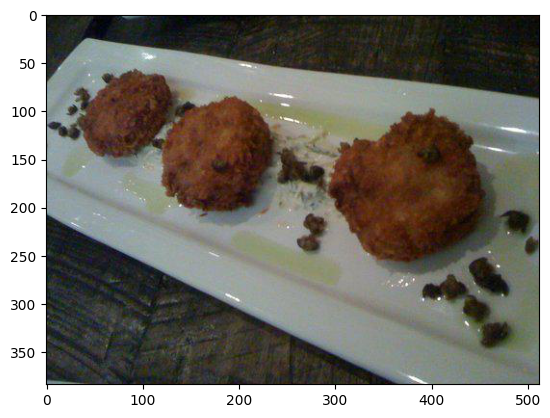

In [137]:
img = Image.open(image_path)
plt.imshow(img)

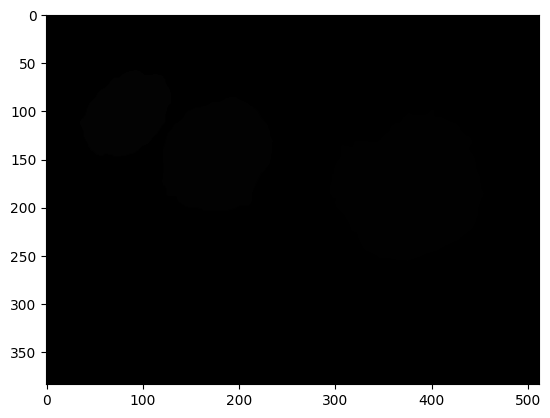

In [138]:
img = Image.open(image_ground_truth)
plt.imshow(img)

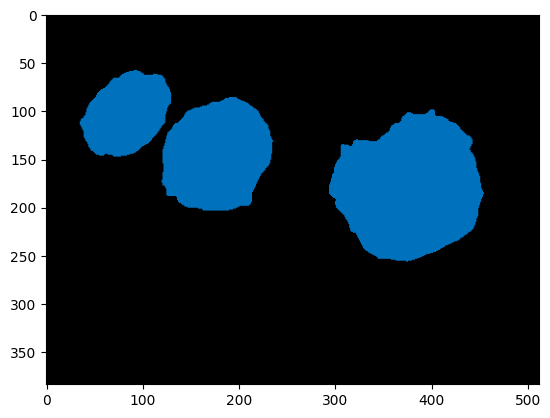

In [139]:
img = Image.open(image_label_coco)
plt.imshow(img)

In [140]:
import cv2

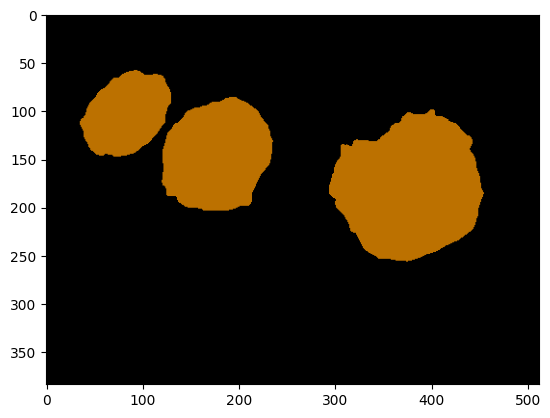

In [141]:
img1 = cv2.imread(image_path)
img2 = cv2.imread(image_label_coco)
plt.imshow(img1)
plt.imshow(img2)

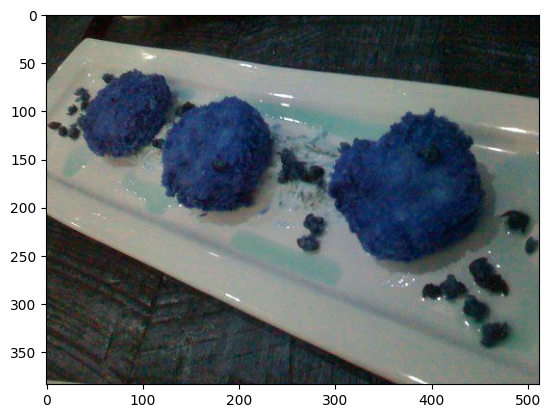

In [142]:
plt.imshow(img1)

In [143]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [144]:
output = np.zeros_like(img1)

In [145]:
# Loop through all the pixels and generate the output image
for i in range(img1.shape[0]):
    for j in range(img1.shape[1]):
        if not gray2[i, j] == 0:
            output[i, j] = img1[i, j]
        else:
            output[i, j] = [100, 100, 100]  # Set color to black


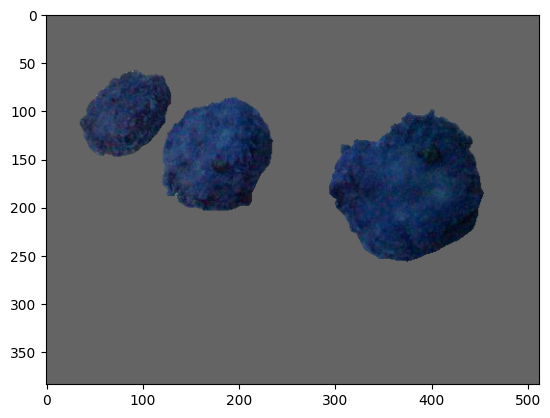

In [146]:
plt.imshow(output)

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
# cv2.imwrite("/content/drive/MyDrive/Grad/beignets/" + img_names[0],output)

In [149]:
def extract_seg(img1, img2):
  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  output = np.zeros_like(img1)
  for i in range(img1.shape[0]):
    for j in range(img1.shape[1]):
        if not gray2[i, j] == 0:
            output[i, j] = img1[i, j]
        else:
            output[i, j] = [100, 100, 100]  # Set color to black
  return output


In [150]:
for i in range(len(img_names)):
  image_path, image_ground_truth, image_label_coco = get_link(img_names[i])
  img1 = cv2.imread(image_path)
  img2 = cv2.imread(image_label_coco)
  if i == 136:
    continue
  output = extract_seg(img1, img2)
  cv2.imwrite("/content/drive/MyDrive/Grad/crab_cakes/" + img_names[i],output)